In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
  sys.path.append("../") 

from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Create Environment

In [2]:
env = gym.envs.make("MountainCar-v0")

[2017-08-12 17:15:13,117] Making new env: MountainCar-v0


In [3]:
env.observation_space.sample()

array([-0.21213569,  0.03012651])

In [4]:
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()


featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.train(scaler.fit_transform(observation_examples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

In [5]:
class Function_Approximator():
    
    def __init__(self):
        
        self.models = []
        for i in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
            
    
    def featurize_state(self, state):
        
        scaled = scaler.transform([state])
        features = featurizer.transform(scaled)
        return features[0]
    
    
    def predict(self, s, a=None):
        
        state_features = self.featurize_state(s)
        if not a:
            return np.array([m.predict([state_features])[0] for m in self.models])
        else:
            return self.models[a].predict([state_features])[0]
        
    def update(self, s, a, y):
       
        features = self.featurize_state(s)
        self.models[a].partial_fit([features], [y])

In [6]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [7]:
def sarsa(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    for i_episode in range(num_episodes):
        
        policy = make_epsilon_greedy_policy(estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        for t in itertools.count():
            
            next_state, reward, end, _ = env.step(action)
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            q_values_next = estimator.predict(next_state)
            td_target = reward + discount_factor * q_values_next[next_action]
            
            estimator.update(state, action, td_target)
            
            if i_episode % 10 == 0:
                print("\rStep {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, reward))
                
            if end:
                break
                
            state = next_state
            action = next_action
    
    return stats

In [8]:
estimator = Function_Approximator()
stats = sarsa(env, estimator, 200, epsilon=0.0)

Step 0 @ Episode 1/200 (-1.0)
Step 1 @ Episode 1/200 (-1.0)
Step 2 @ Episode 1/200 (-1.0)
Step 3 @ Episode 1/200 (-1.0)
Step 4 @ Episode 1/200 (-1.0)
Step 5 @ Episode 1/200 (-1.0)
Step 6 @ Episode 1/200 (-1.0)
Step 7 @ Episode 1/200 (-1.0)
Step 8 @ Episode 1/200 (-1.0)
Step 9 @ Episode 1/200 (-1.0)
Step 10 @ Episode 1/200 (-1.0)
Step 11 @ Episode 1/200 (-1.0)
Step 12 @ Episode 1/200 (-1.0)
Step 13 @ Episode 1/200 (-1.0)
Step 14 @ Episode 1/200 (-1.0)
Step 15 @ Episode 1/200 (-1.0)
Step 16 @ Episode 1/200 (-1.0)
Step 17 @ Episode 1/200 (-1.0)
Step 18 @ Episode 1/200 (-1.0)
Step 19 @ Episode 1/200 (-1.0)
Step 20 @ Episode 1/200 (-1.0)
Step 21 @ Episode 1/200 (-1.0)
Step 22 @ Episode 1/200 (-1.0)
Step 23 @ Episode 1/200 (-1.0)
Step 24 @ Episode 1/200 (-1.0)
Step 25 @ Episode 1/200 (-1.0)
Step 26 @ Episode 1/200 (-1.0)
Step 27 @ Episode 1/200 (-1.0)
Step 28 @ Episode 1/200 (-1.0)
Step 29 @ Episode 1/200 (-1.0)
Step 30 @ Episode 1/200 (-1.0)
Step 31 @ Episode 1/200 (-1.0)
Step 32 @ Episode 

Step 72 @ Episode 11/200 (-1.0)
Step 73 @ Episode 11/200 (-1.0)
Step 74 @ Episode 11/200 (-1.0)
Step 75 @ Episode 11/200 (-1.0)
Step 76 @ Episode 11/200 (-1.0)
Step 77 @ Episode 11/200 (-1.0)
Step 78 @ Episode 11/200 (-1.0)
Step 79 @ Episode 11/200 (-1.0)
Step 80 @ Episode 11/200 (-1.0)
Step 81 @ Episode 11/200 (-1.0)
Step 82 @ Episode 11/200 (-1.0)
Step 83 @ Episode 11/200 (-1.0)
Step 84 @ Episode 11/200 (-1.0)
Step 85 @ Episode 11/200 (-1.0)
Step 86 @ Episode 11/200 (-1.0)
Step 87 @ Episode 11/200 (-1.0)
Step 88 @ Episode 11/200 (-1.0)
Step 89 @ Episode 11/200 (-1.0)
Step 90 @ Episode 11/200 (-1.0)
Step 91 @ Episode 11/200 (-1.0)
Step 92 @ Episode 11/200 (-1.0)
Step 93 @ Episode 11/200 (-1.0)
Step 94 @ Episode 11/200 (-1.0)
Step 95 @ Episode 11/200 (-1.0)
Step 96 @ Episode 11/200 (-1.0)
Step 97 @ Episode 11/200 (-1.0)
Step 98 @ Episode 11/200 (-1.0)
Step 99 @ Episode 11/200 (-1.0)
Step 100 @ Episode 11/200 (-1.0)
Step 101 @ Episode 11/200 (-1.0)
Step 102 @ Episode 11/200 (-1.0)
Step 

Step 143 @ Episode 21/200 (-1.0)
Step 144 @ Episode 21/200 (-1.0)
Step 145 @ Episode 21/200 (-1.0)
Step 146 @ Episode 21/200 (-1.0)
Step 147 @ Episode 21/200 (-1.0)
Step 148 @ Episode 21/200 (-1.0)
Step 149 @ Episode 21/200 (-1.0)
Step 150 @ Episode 21/200 (-1.0)
Step 151 @ Episode 21/200 (-1.0)
Step 152 @ Episode 21/200 (-1.0)
Step 153 @ Episode 21/200 (-1.0)
Step 154 @ Episode 21/200 (-1.0)
Step 155 @ Episode 21/200 (-1.0)
Step 156 @ Episode 21/200 (-1.0)
Step 157 @ Episode 21/200 (-1.0)
Step 158 @ Episode 21/200 (-1.0)
Step 159 @ Episode 21/200 (-1.0)
Step 160 @ Episode 21/200 (-1.0)
Step 161 @ Episode 21/200 (-1.0)
Step 162 @ Episode 21/200 (-1.0)
Step 163 @ Episode 21/200 (-1.0)
Step 164 @ Episode 21/200 (-1.0)
Step 165 @ Episode 21/200 (-1.0)
Step 166 @ Episode 21/200 (-1.0)
Step 167 @ Episode 21/200 (-1.0)
Step 168 @ Episode 21/200 (-1.0)
Step 169 @ Episode 21/200 (-1.0)
Step 170 @ Episode 21/200 (-1.0)
Step 171 @ Episode 21/200 (-1.0)
Step 172 @ Episode 21/200 (-1.0)
Step 173 @

Step 0 @ Episode 41/200 (-1.0)
Step 1 @ Episode 41/200 (-1.0)
Step 2 @ Episode 41/200 (-1.0)
Step 3 @ Episode 41/200 (-1.0)
Step 4 @ Episode 41/200 (-1.0)
Step 5 @ Episode 41/200 (-1.0)
Step 6 @ Episode 41/200 (-1.0)
Step 7 @ Episode 41/200 (-1.0)
Step 8 @ Episode 41/200 (-1.0)
Step 9 @ Episode 41/200 (-1.0)
Step 10 @ Episode 41/200 (-1.0)
Step 11 @ Episode 41/200 (-1.0)
Step 12 @ Episode 41/200 (-1.0)
Step 13 @ Episode 41/200 (-1.0)
Step 14 @ Episode 41/200 (-1.0)
Step 15 @ Episode 41/200 (-1.0)
Step 16 @ Episode 41/200 (-1.0)
Step 17 @ Episode 41/200 (-1.0)
Step 18 @ Episode 41/200 (-1.0)
Step 19 @ Episode 41/200 (-1.0)
Step 20 @ Episode 41/200 (-1.0)
Step 21 @ Episode 41/200 (-1.0)
Step 22 @ Episode 41/200 (-1.0)
Step 23 @ Episode 41/200 (-1.0)
Step 24 @ Episode 41/200 (-1.0)
Step 25 @ Episode 41/200 (-1.0)
Step 26 @ Episode 41/200 (-1.0)
Step 27 @ Episode 41/200 (-1.0)
Step 28 @ Episode 41/200 (-1.0)
Step 29 @ Episode 41/200 (-1.0)
Step 30 @ Episode 41/200 (-1.0)
Step 31 @ Episode 

Step 72 @ Episode 51/200 (-1.0)
Step 73 @ Episode 51/200 (-1.0)
Step 74 @ Episode 51/200 (-1.0)
Step 75 @ Episode 51/200 (-1.0)
Step 76 @ Episode 51/200 (-1.0)
Step 77 @ Episode 51/200 (-1.0)
Step 78 @ Episode 51/200 (-1.0)
Step 79 @ Episode 51/200 (-1.0)
Step 80 @ Episode 51/200 (-1.0)
Step 81 @ Episode 51/200 (-1.0)
Step 82 @ Episode 51/200 (-1.0)
Step 83 @ Episode 51/200 (-1.0)
Step 84 @ Episode 51/200 (-1.0)
Step 85 @ Episode 51/200 (-1.0)
Step 86 @ Episode 51/200 (-1.0)
Step 87 @ Episode 51/200 (-1.0)
Step 88 @ Episode 51/200 (-1.0)
Step 89 @ Episode 51/200 (-1.0)
Step 90 @ Episode 51/200 (-1.0)
Step 91 @ Episode 51/200 (-1.0)
Step 92 @ Episode 51/200 (-1.0)
Step 93 @ Episode 51/200 (-1.0)
Step 94 @ Episode 51/200 (-1.0)
Step 95 @ Episode 51/200 (-1.0)
Step 96 @ Episode 51/200 (-1.0)
Step 97 @ Episode 51/200 (-1.0)
Step 98 @ Episode 51/200 (-1.0)
Step 99 @ Episode 51/200 (-1.0)
Step 100 @ Episode 51/200 (-1.0)
Step 101 @ Episode 51/200 (-1.0)
Step 102 @ Episode 51/200 (-1.0)
Step 

Step 49 @ Episode 71/200 (-1.0)
Step 50 @ Episode 71/200 (-1.0)
Step 51 @ Episode 71/200 (-1.0)
Step 52 @ Episode 71/200 (-1.0)
Step 53 @ Episode 71/200 (-1.0)
Step 54 @ Episode 71/200 (-1.0)
Step 55 @ Episode 71/200 (-1.0)
Step 56 @ Episode 71/200 (-1.0)
Step 57 @ Episode 71/200 (-1.0)
Step 58 @ Episode 71/200 (-1.0)
Step 59 @ Episode 71/200 (-1.0)
Step 60 @ Episode 71/200 (-1.0)
Step 61 @ Episode 71/200 (-1.0)
Step 62 @ Episode 71/200 (-1.0)
Step 63 @ Episode 71/200 (-1.0)
Step 64 @ Episode 71/200 (-1.0)
Step 65 @ Episode 71/200 (-1.0)
Step 66 @ Episode 71/200 (-1.0)
Step 67 @ Episode 71/200 (-1.0)
Step 68 @ Episode 71/200 (-1.0)
Step 69 @ Episode 71/200 (-1.0)
Step 70 @ Episode 71/200 (-1.0)
Step 71 @ Episode 71/200 (-1.0)
Step 72 @ Episode 71/200 (-1.0)
Step 73 @ Episode 71/200 (-1.0)
Step 74 @ Episode 71/200 (-1.0)
Step 75 @ Episode 71/200 (-1.0)
Step 76 @ Episode 71/200 (-1.0)
Step 77 @ Episode 71/200 (-1.0)
Step 78 @ Episode 71/200 (-1.0)
Step 79 @ Episode 71/200 (-1.0)
Step 80 

Step 169 @ Episode 81/200 (-1.0)
Step 170 @ Episode 81/200 (-1.0)
Step 171 @ Episode 81/200 (-1.0)
Step 172 @ Episode 81/200 (-1.0)
Step 173 @ Episode 81/200 (-1.0)
Step 174 @ Episode 81/200 (-1.0)
Step 175 @ Episode 81/200 (-1.0)
Step 176 @ Episode 81/200 (-1.0)
Step 177 @ Episode 81/200 (-1.0)
Step 178 @ Episode 81/200 (-1.0)
Step 179 @ Episode 81/200 (-1.0)
Step 180 @ Episode 81/200 (-1.0)
Step 181 @ Episode 81/200 (-1.0)
Step 182 @ Episode 81/200 (-1.0)
Step 183 @ Episode 81/200 (-1.0)
Step 184 @ Episode 81/200 (-1.0)
Step 185 @ Episode 81/200 (-1.0)
Step 186 @ Episode 81/200 (-1.0)
Step 187 @ Episode 81/200 (-1.0)
Step 188 @ Episode 81/200 (-1.0)
Step 189 @ Episode 81/200 (-1.0)
Step 190 @ Episode 81/200 (-1.0)
Step 191 @ Episode 81/200 (-1.0)
Step 192 @ Episode 81/200 (-1.0)
Step 193 @ Episode 81/200 (-1.0)
Step 194 @ Episode 81/200 (-1.0)
Step 195 @ Episode 81/200 (-1.0)
Step 196 @ Episode 81/200 (-1.0)
Step 197 @ Episode 81/200 (-1.0)
Step 198 @ Episode 81/200 (-1.0)
Step 199 @

Step 25 @ Episode 111/200 (-1.0)
Step 26 @ Episode 111/200 (-1.0)
Step 27 @ Episode 111/200 (-1.0)
Step 28 @ Episode 111/200 (-1.0)
Step 29 @ Episode 111/200 (-1.0)
Step 30 @ Episode 111/200 (-1.0)
Step 31 @ Episode 111/200 (-1.0)
Step 32 @ Episode 111/200 (-1.0)
Step 33 @ Episode 111/200 (-1.0)
Step 34 @ Episode 111/200 (-1.0)
Step 35 @ Episode 111/200 (-1.0)
Step 36 @ Episode 111/200 (-1.0)
Step 37 @ Episode 111/200 (-1.0)
Step 38 @ Episode 111/200 (-1.0)
Step 39 @ Episode 111/200 (-1.0)
Step 40 @ Episode 111/200 (-1.0)
Step 41 @ Episode 111/200 (-1.0)
Step 42 @ Episode 111/200 (-1.0)
Step 43 @ Episode 111/200 (-1.0)
Step 44 @ Episode 111/200 (-1.0)
Step 45 @ Episode 111/200 (-1.0)
Step 46 @ Episode 111/200 (-1.0)
Step 47 @ Episode 111/200 (-1.0)
Step 48 @ Episode 111/200 (-1.0)
Step 49 @ Episode 111/200 (-1.0)
Step 50 @ Episode 111/200 (-1.0)
Step 51 @ Episode 111/200 (-1.0)
Step 52 @ Episode 111/200 (-1.0)
Step 53 @ Episode 111/200 (-1.0)
Step 54 @ Episode 111/200 (-1.0)
Step 55 @ 

Step 97 @ Episode 121/200 (-1.0)
Step 98 @ Episode 121/200 (-1.0)
Step 99 @ Episode 121/200 (-1.0)
Step 100 @ Episode 121/200 (-1.0)
Step 101 @ Episode 121/200 (-1.0)
Step 102 @ Episode 121/200 (-1.0)
Step 103 @ Episode 121/200 (-1.0)
Step 104 @ Episode 121/200 (-1.0)
Step 105 @ Episode 121/200 (-1.0)
Step 106 @ Episode 121/200 (-1.0)
Step 107 @ Episode 121/200 (-1.0)
Step 108 @ Episode 121/200 (-1.0)
Step 109 @ Episode 121/200 (-1.0)
Step 110 @ Episode 121/200 (-1.0)
Step 111 @ Episode 121/200 (-1.0)
Step 112 @ Episode 121/200 (-1.0)
Step 113 @ Episode 121/200 (-1.0)
Step 114 @ Episode 121/200 (-1.0)
Step 115 @ Episode 121/200 (-1.0)
Step 116 @ Episode 121/200 (-1.0)
Step 117 @ Episode 121/200 (-1.0)
Step 118 @ Episode 121/200 (-1.0)
Step 119 @ Episode 121/200 (-1.0)
Step 120 @ Episode 121/200 (-1.0)
Step 121 @ Episode 121/200 (-1.0)
Step 122 @ Episode 121/200 (-1.0)
Step 123 @ Episode 121/200 (-1.0)
Step 124 @ Episode 121/200 (-1.0)
Step 125 @ Episode 121/200 (-1.0)
Step 126 @ Episod

Step 97 @ Episode 141/200 (-1.0)
Step 98 @ Episode 141/200 (-1.0)
Step 99 @ Episode 141/200 (-1.0)
Step 100 @ Episode 141/200 (-1.0)
Step 101 @ Episode 141/200 (-1.0)
Step 102 @ Episode 141/200 (-1.0)
Step 0 @ Episode 151/200 (-1.0)
Step 1 @ Episode 151/200 (-1.0)
Step 2 @ Episode 151/200 (-1.0)
Step 3 @ Episode 151/200 (-1.0)
Step 4 @ Episode 151/200 (-1.0)
Step 5 @ Episode 151/200 (-1.0)
Step 6 @ Episode 151/200 (-1.0)
Step 7 @ Episode 151/200 (-1.0)
Step 8 @ Episode 151/200 (-1.0)
Step 9 @ Episode 151/200 (-1.0)
Step 10 @ Episode 151/200 (-1.0)
Step 11 @ Episode 151/200 (-1.0)
Step 12 @ Episode 151/200 (-1.0)
Step 13 @ Episode 151/200 (-1.0)
Step 14 @ Episode 151/200 (-1.0)
Step 15 @ Episode 151/200 (-1.0)
Step 16 @ Episode 151/200 (-1.0)
Step 17 @ Episode 151/200 (-1.0)
Step 18 @ Episode 151/200 (-1.0)
Step 19 @ Episode 151/200 (-1.0)
Step 20 @ Episode 151/200 (-1.0)
Step 21 @ Episode 151/200 (-1.0)
Step 22 @ Episode 151/200 (-1.0)
Step 23 @ Episode 151/200 (-1.0)
Step 24 @ Episode

Step 25 @ Episode 171/200 (-1.0)
Step 26 @ Episode 171/200 (-1.0)
Step 27 @ Episode 171/200 (-1.0)
Step 28 @ Episode 171/200 (-1.0)
Step 29 @ Episode 171/200 (-1.0)
Step 30 @ Episode 171/200 (-1.0)
Step 31 @ Episode 171/200 (-1.0)
Step 32 @ Episode 171/200 (-1.0)
Step 33 @ Episode 171/200 (-1.0)
Step 34 @ Episode 171/200 (-1.0)
Step 35 @ Episode 171/200 (-1.0)
Step 36 @ Episode 171/200 (-1.0)
Step 37 @ Episode 171/200 (-1.0)
Step 38 @ Episode 171/200 (-1.0)
Step 39 @ Episode 171/200 (-1.0)
Step 40 @ Episode 171/200 (-1.0)
Step 41 @ Episode 171/200 (-1.0)
Step 42 @ Episode 171/200 (-1.0)
Step 43 @ Episode 171/200 (-1.0)
Step 44 @ Episode 171/200 (-1.0)
Step 45 @ Episode 171/200 (-1.0)
Step 46 @ Episode 171/200 (-1.0)
Step 47 @ Episode 171/200 (-1.0)
Step 48 @ Episode 171/200 (-1.0)
Step 49 @ Episode 171/200 (-1.0)
Step 50 @ Episode 171/200 (-1.0)
Step 51 @ Episode 171/200 (-1.0)
Step 52 @ Episode 171/200 (-1.0)
Step 53 @ Episode 171/200 (-1.0)
Step 54 @ Episode 171/200 (-1.0)
Step 55 @ 

Step 25 @ Episode 191/200 (-1.0)
Step 26 @ Episode 191/200 (-1.0)
Step 27 @ Episode 191/200 (-1.0)
Step 28 @ Episode 191/200 (-1.0)
Step 29 @ Episode 191/200 (-1.0)
Step 30 @ Episode 191/200 (-1.0)
Step 31 @ Episode 191/200 (-1.0)
Step 32 @ Episode 191/200 (-1.0)
Step 33 @ Episode 191/200 (-1.0)
Step 34 @ Episode 191/200 (-1.0)
Step 35 @ Episode 191/200 (-1.0)
Step 36 @ Episode 191/200 (-1.0)
Step 37 @ Episode 191/200 (-1.0)
Step 38 @ Episode 191/200 (-1.0)
Step 39 @ Episode 191/200 (-1.0)
Step 40 @ Episode 191/200 (-1.0)
Step 41 @ Episode 191/200 (-1.0)
Step 42 @ Episode 191/200 (-1.0)
Step 43 @ Episode 191/200 (-1.0)
Step 44 @ Episode 191/200 (-1.0)
Step 45 @ Episode 191/200 (-1.0)
Step 46 @ Episode 191/200 (-1.0)
Step 47 @ Episode 191/200 (-1.0)
Step 48 @ Episode 191/200 (-1.0)
Step 49 @ Episode 191/200 (-1.0)
Step 50 @ Episode 191/200 (-1.0)
Step 51 @ Episode 191/200 (-1.0)
Step 52 @ Episode 191/200 (-1.0)
Step 53 @ Episode 191/200 (-1.0)
Step 54 @ Episode 191/200 (-1.0)
Step 55 @ 

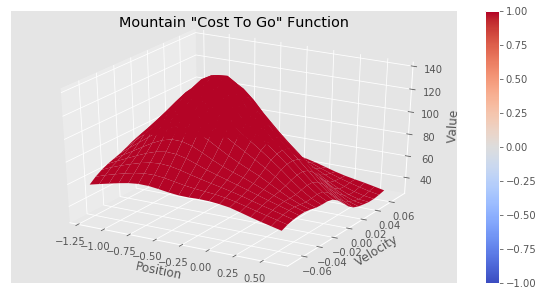

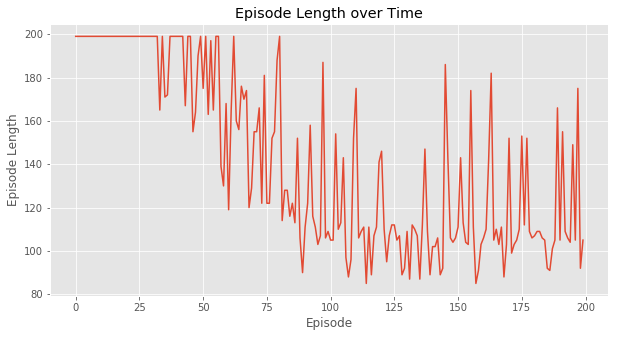

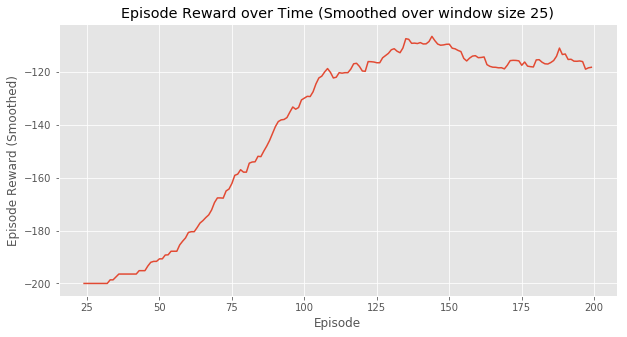

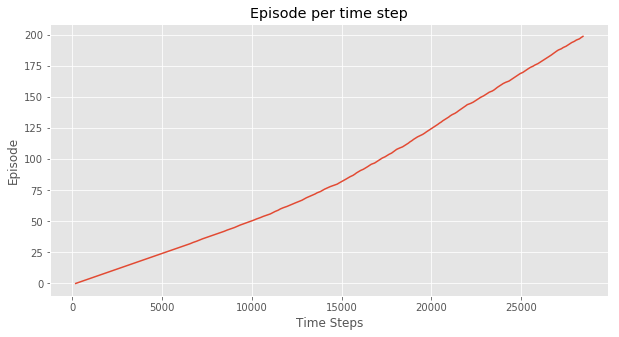

(<matplotlib.figure.Figure at 0x113a8e450>,
 <matplotlib.figure.Figure at 0x11459d4d0>)

In [9]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)

/Users/adityavyas/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


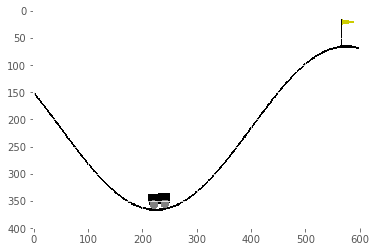

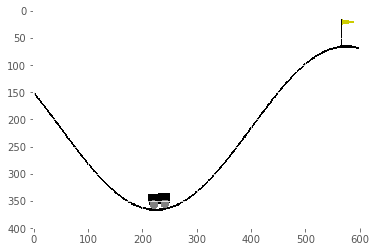

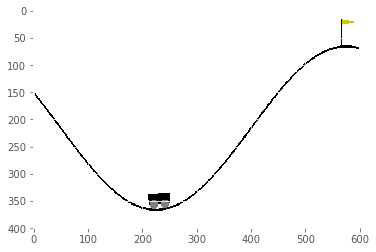

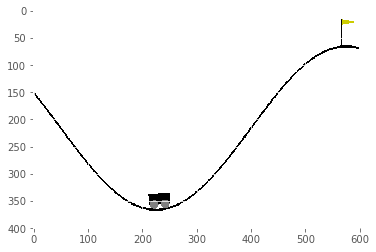

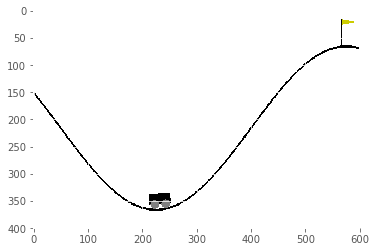

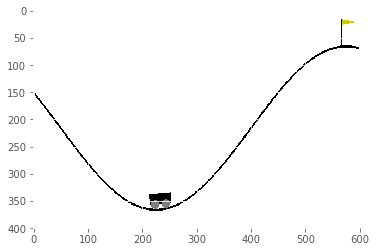

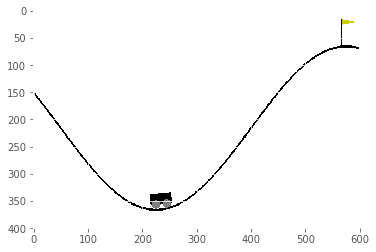

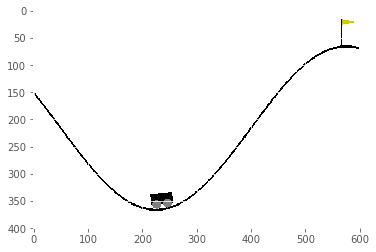

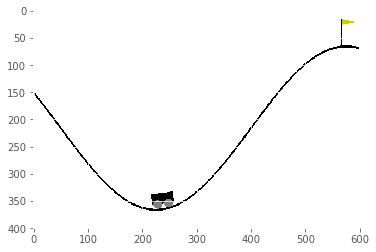

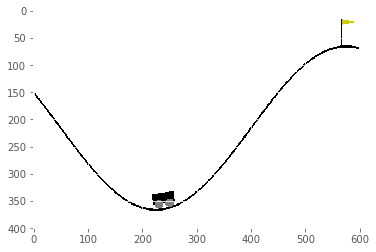

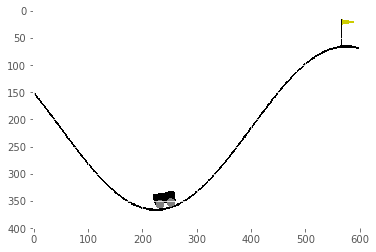

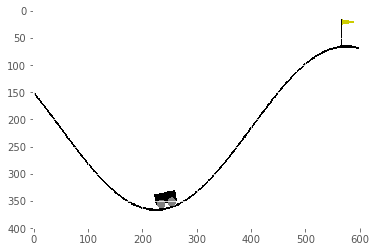

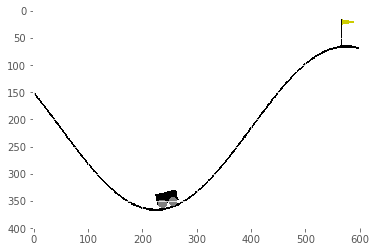

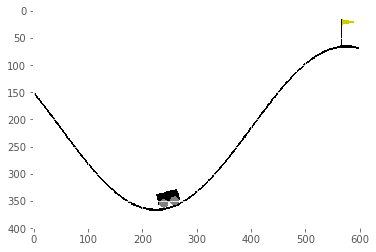

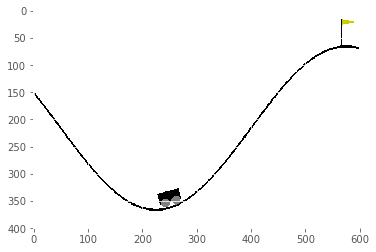

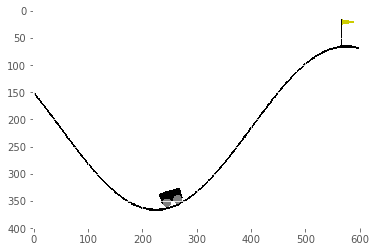

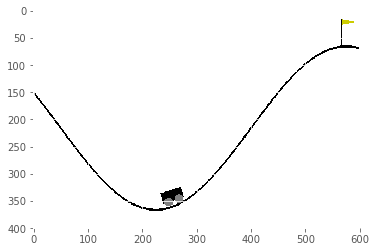

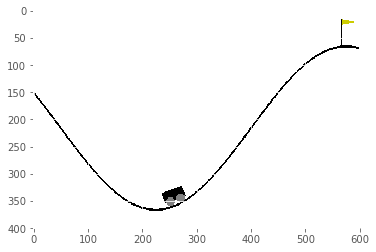

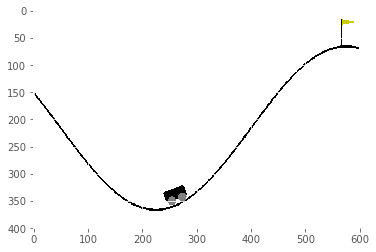

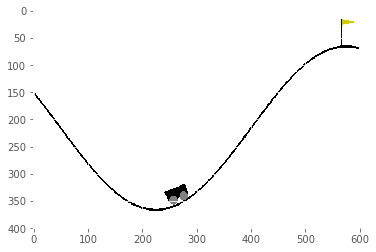

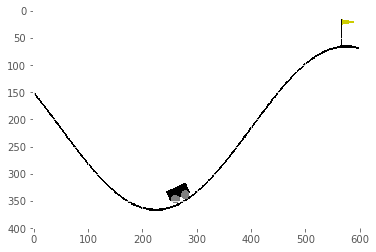

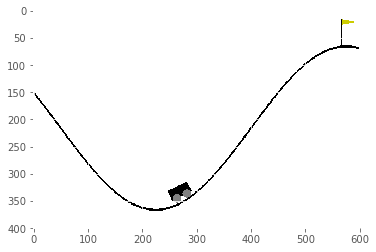

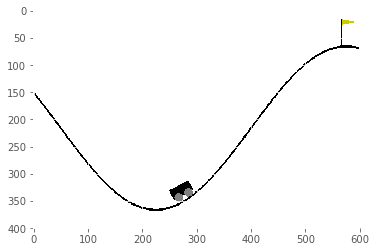

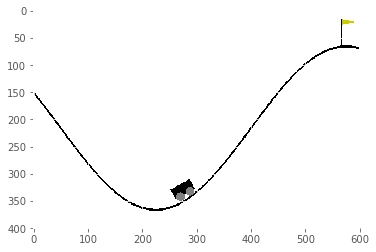

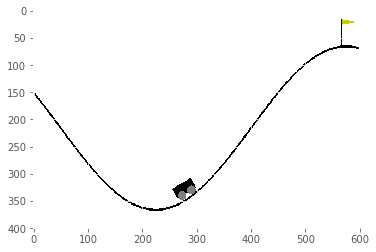

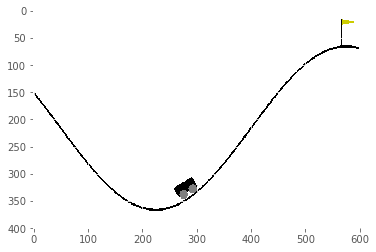

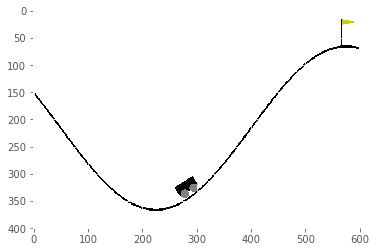

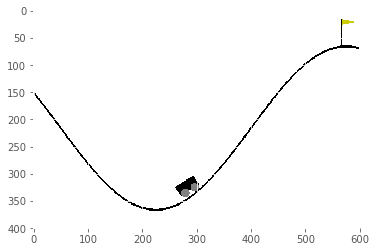

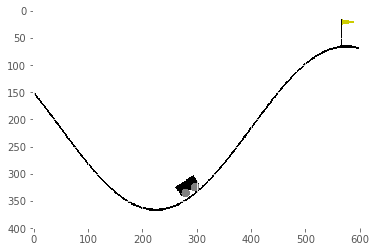

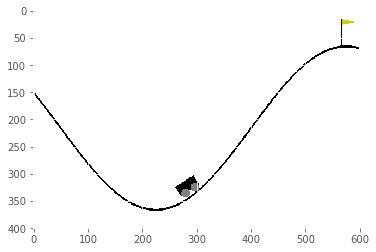

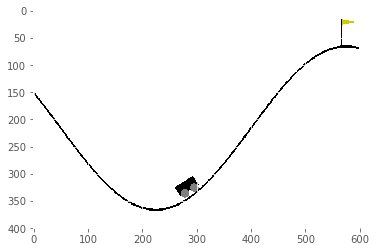

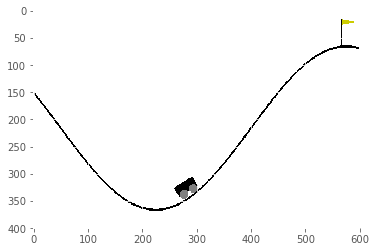

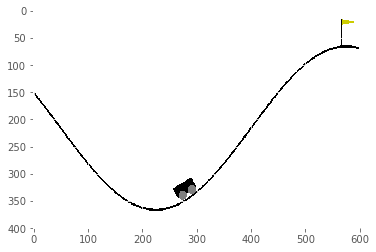

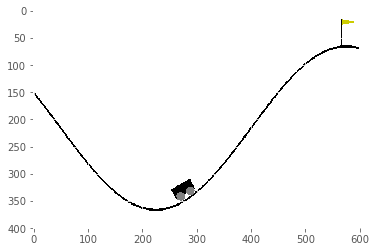

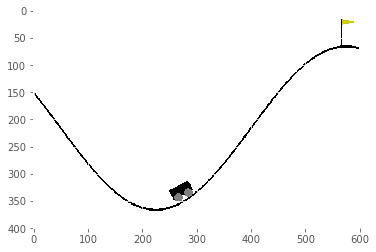

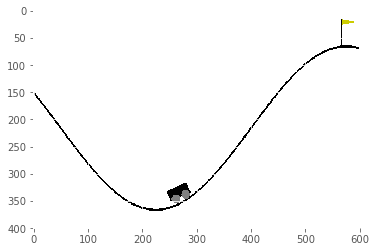

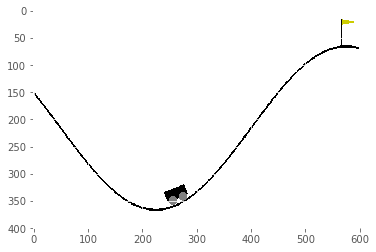

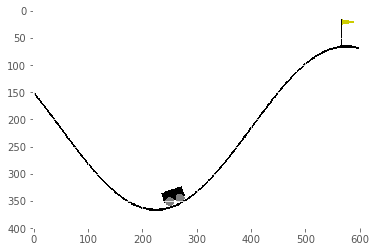

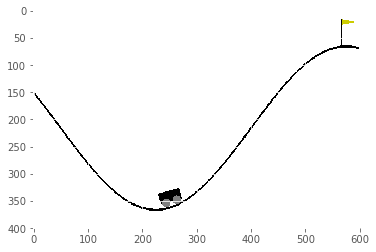

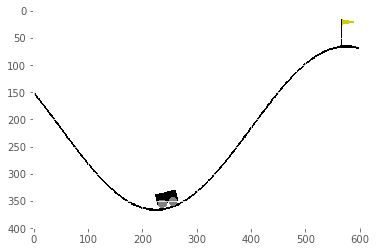

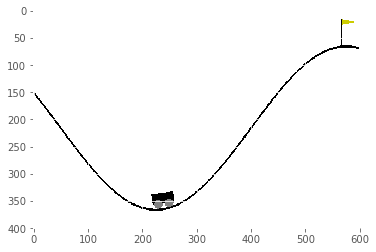

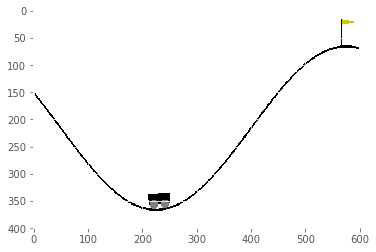

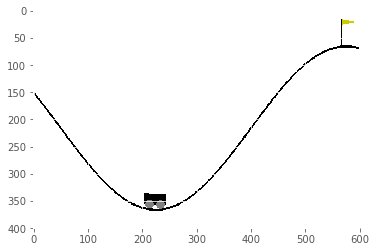

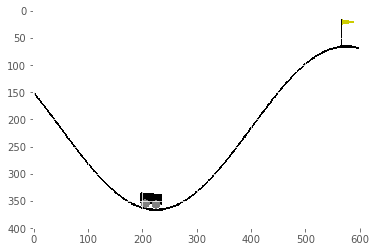

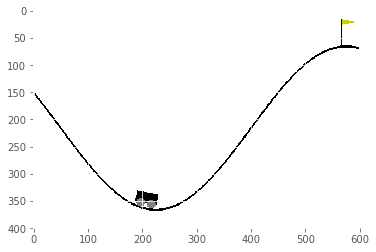

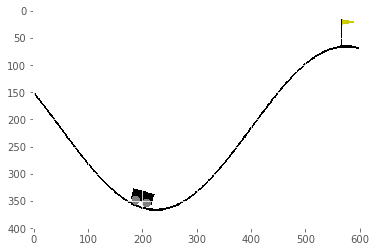

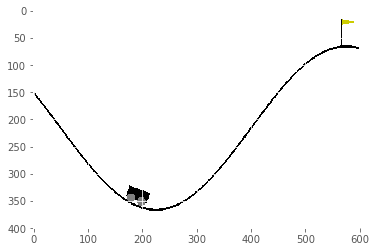

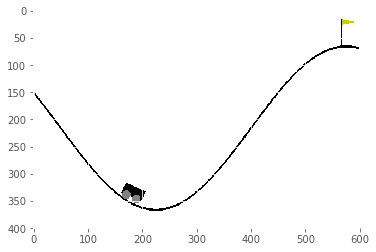

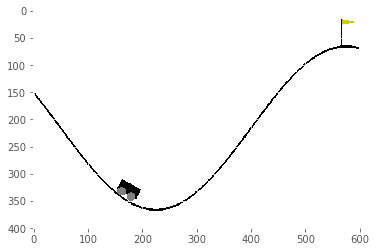

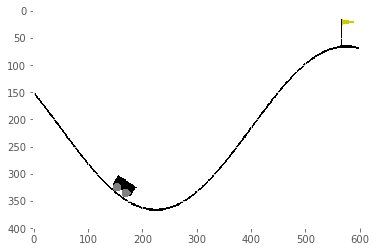

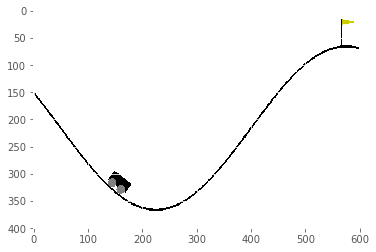

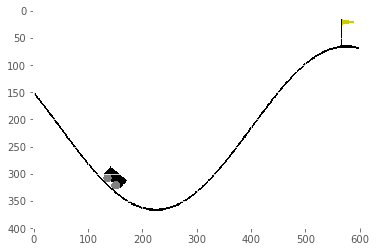

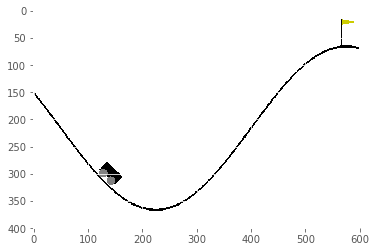

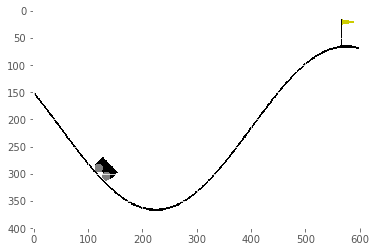

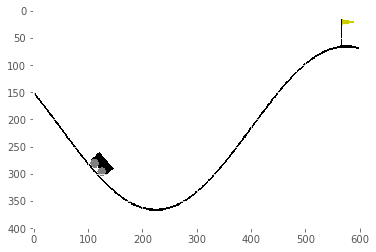

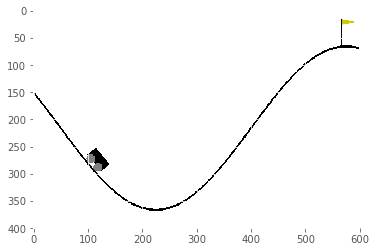

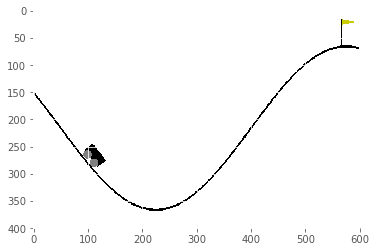

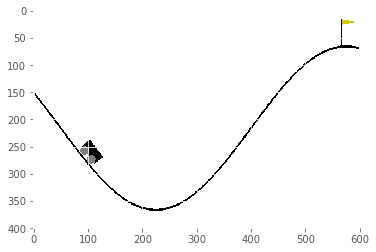

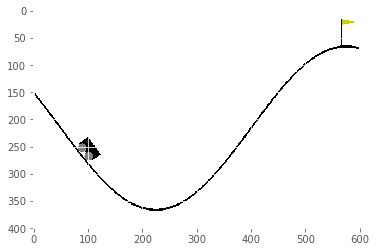

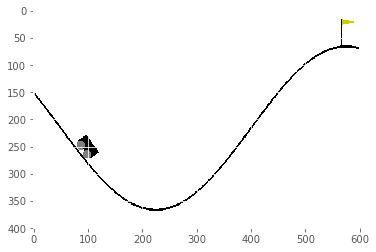

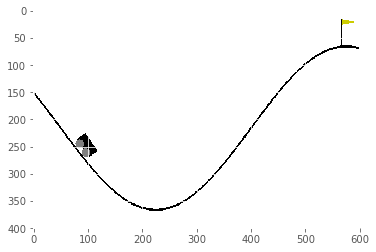

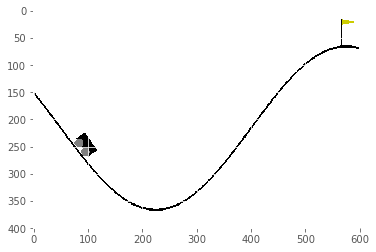

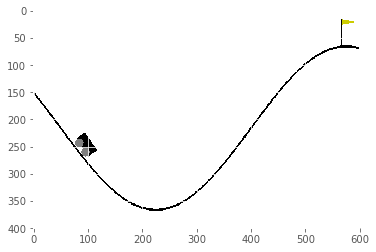

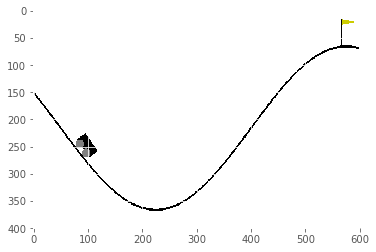

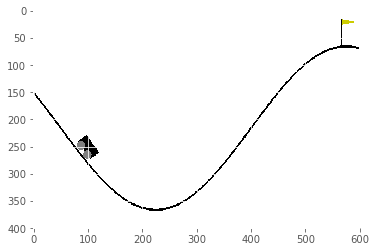

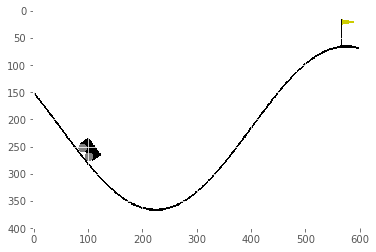

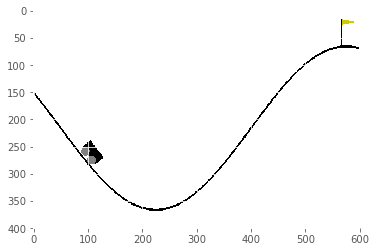

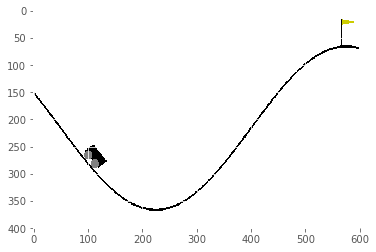

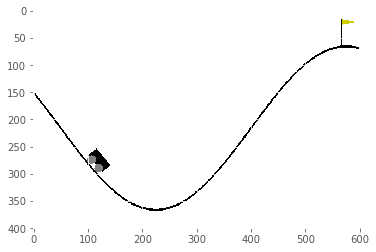

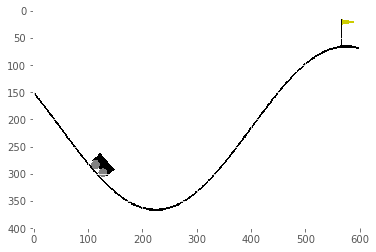

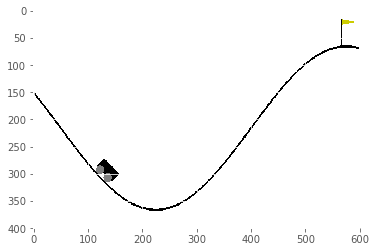

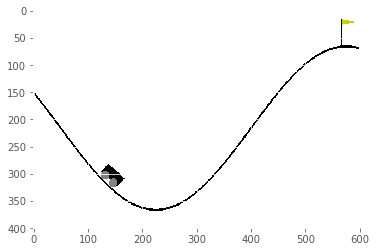

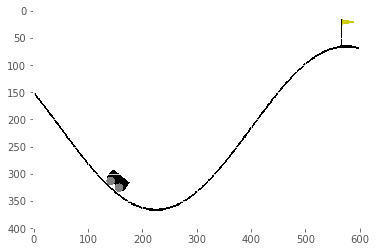

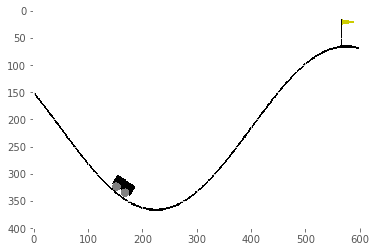

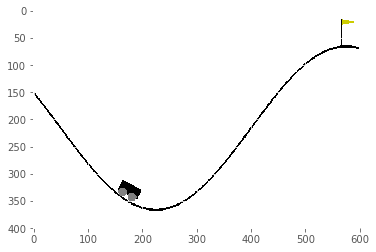

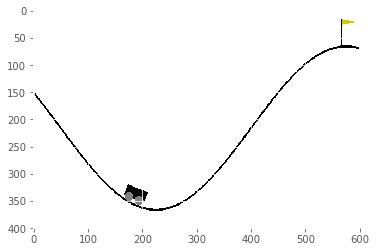

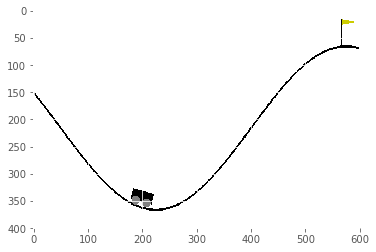

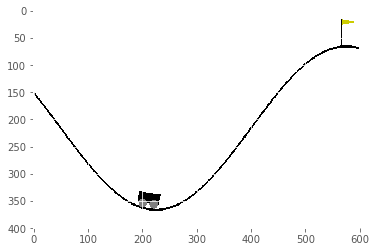

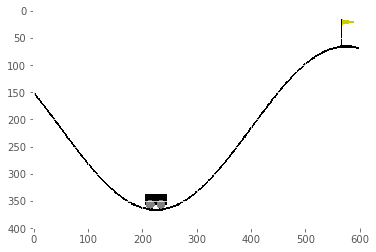

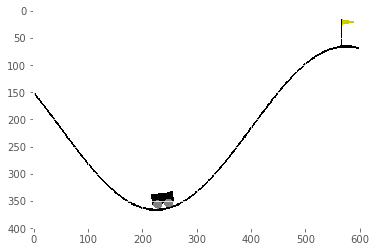

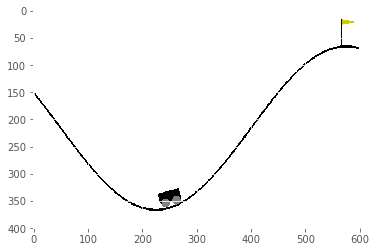

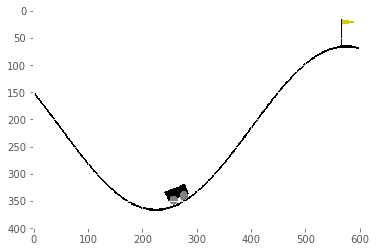

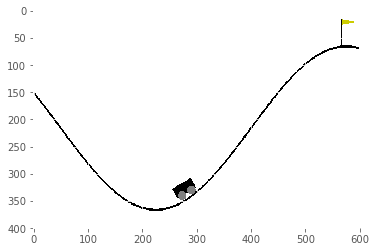

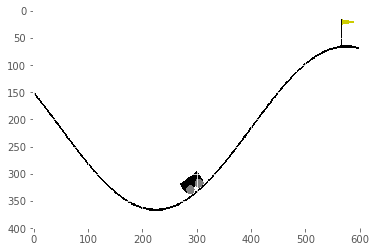

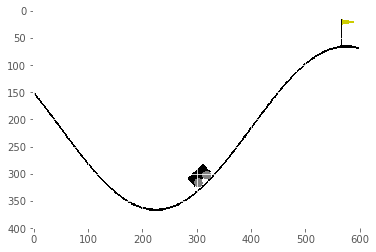

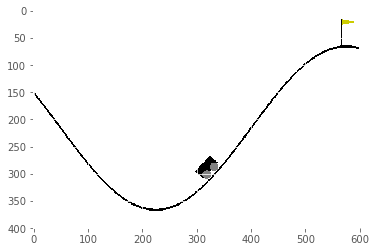

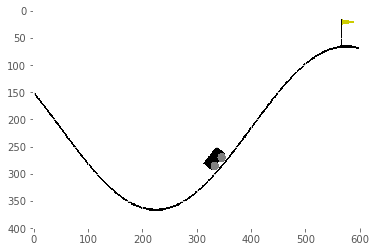

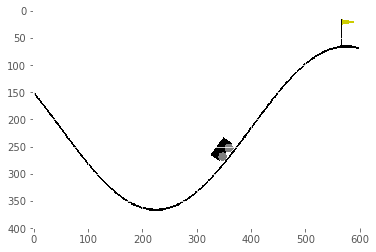

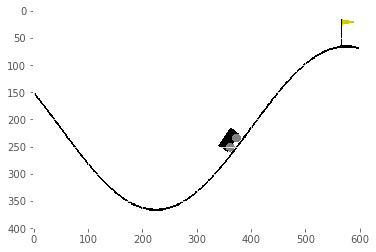

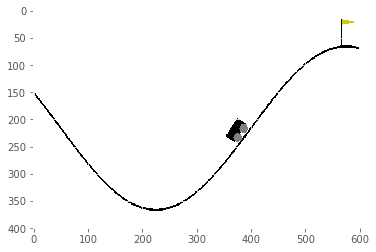

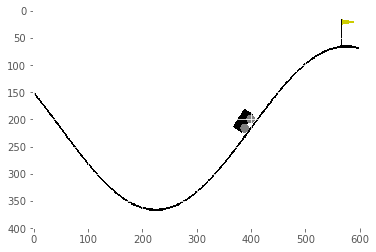

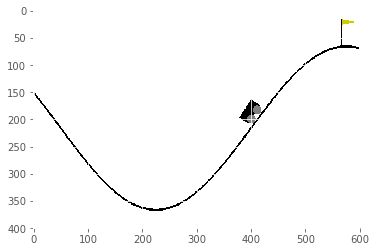

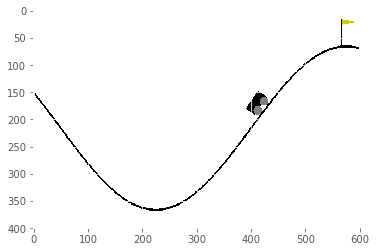

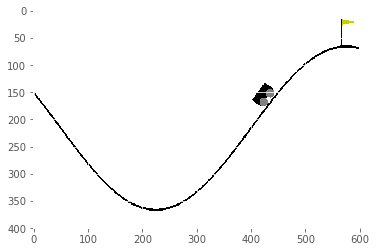

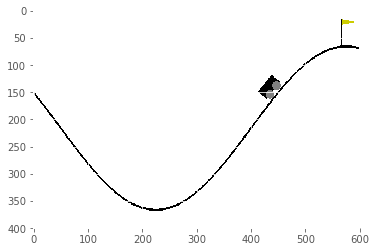

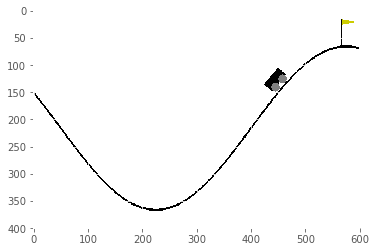

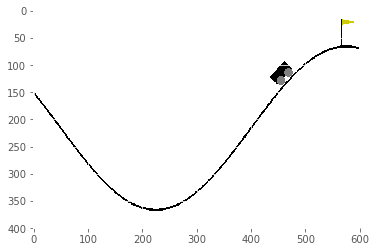

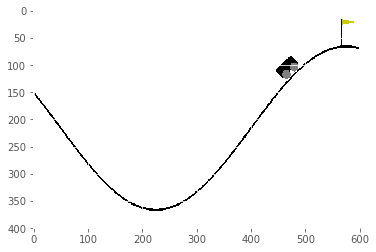

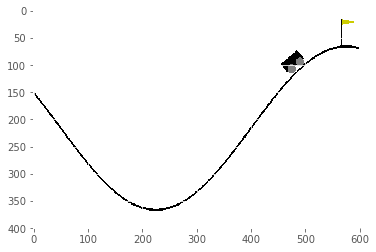

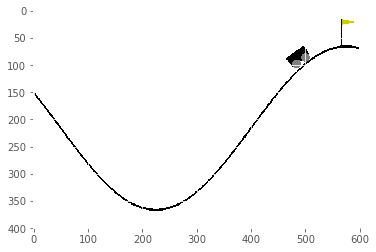

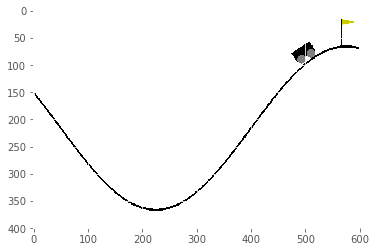

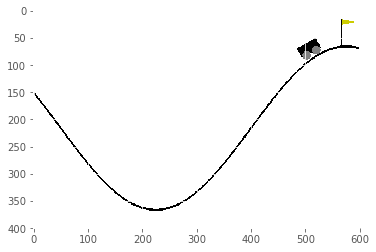

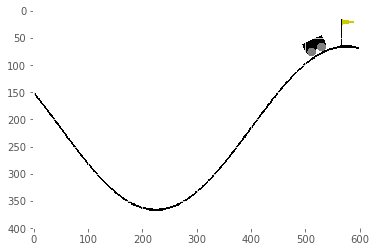

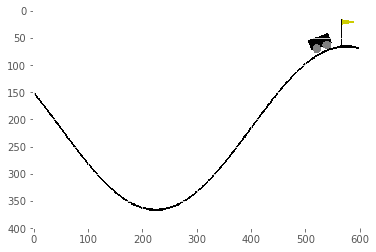

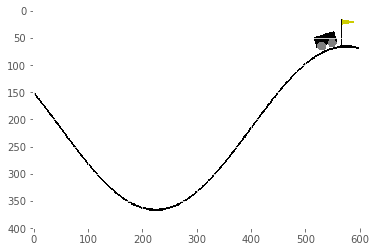

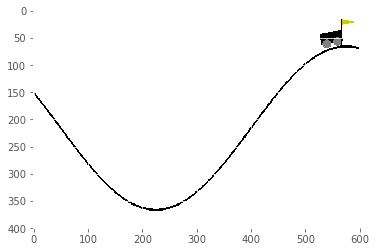

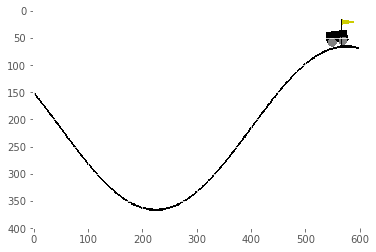

In [10]:
state = env.reset()
plt.figure()
plt.imshow(env.render(mode='rgb_array'))
while(True):
    q_values = estimator.predict(state)
    best_action = np.argmax(q_values)
    plt.figure()
    plt.imshow(env.render(mode='rgb_array'))
    
    next_state, reward, end, _ = env.step(best_action)
    if end:
        break
        
    state = next_state
    env.render(close=True)
env.render(close=True)